## Parity Plot

Combine individual parity plots into one large figure containing all parity plots for every operator

Making GHGSat plots...
Making Kairos plots...
Making MethaneAIR plots...
Figure saved


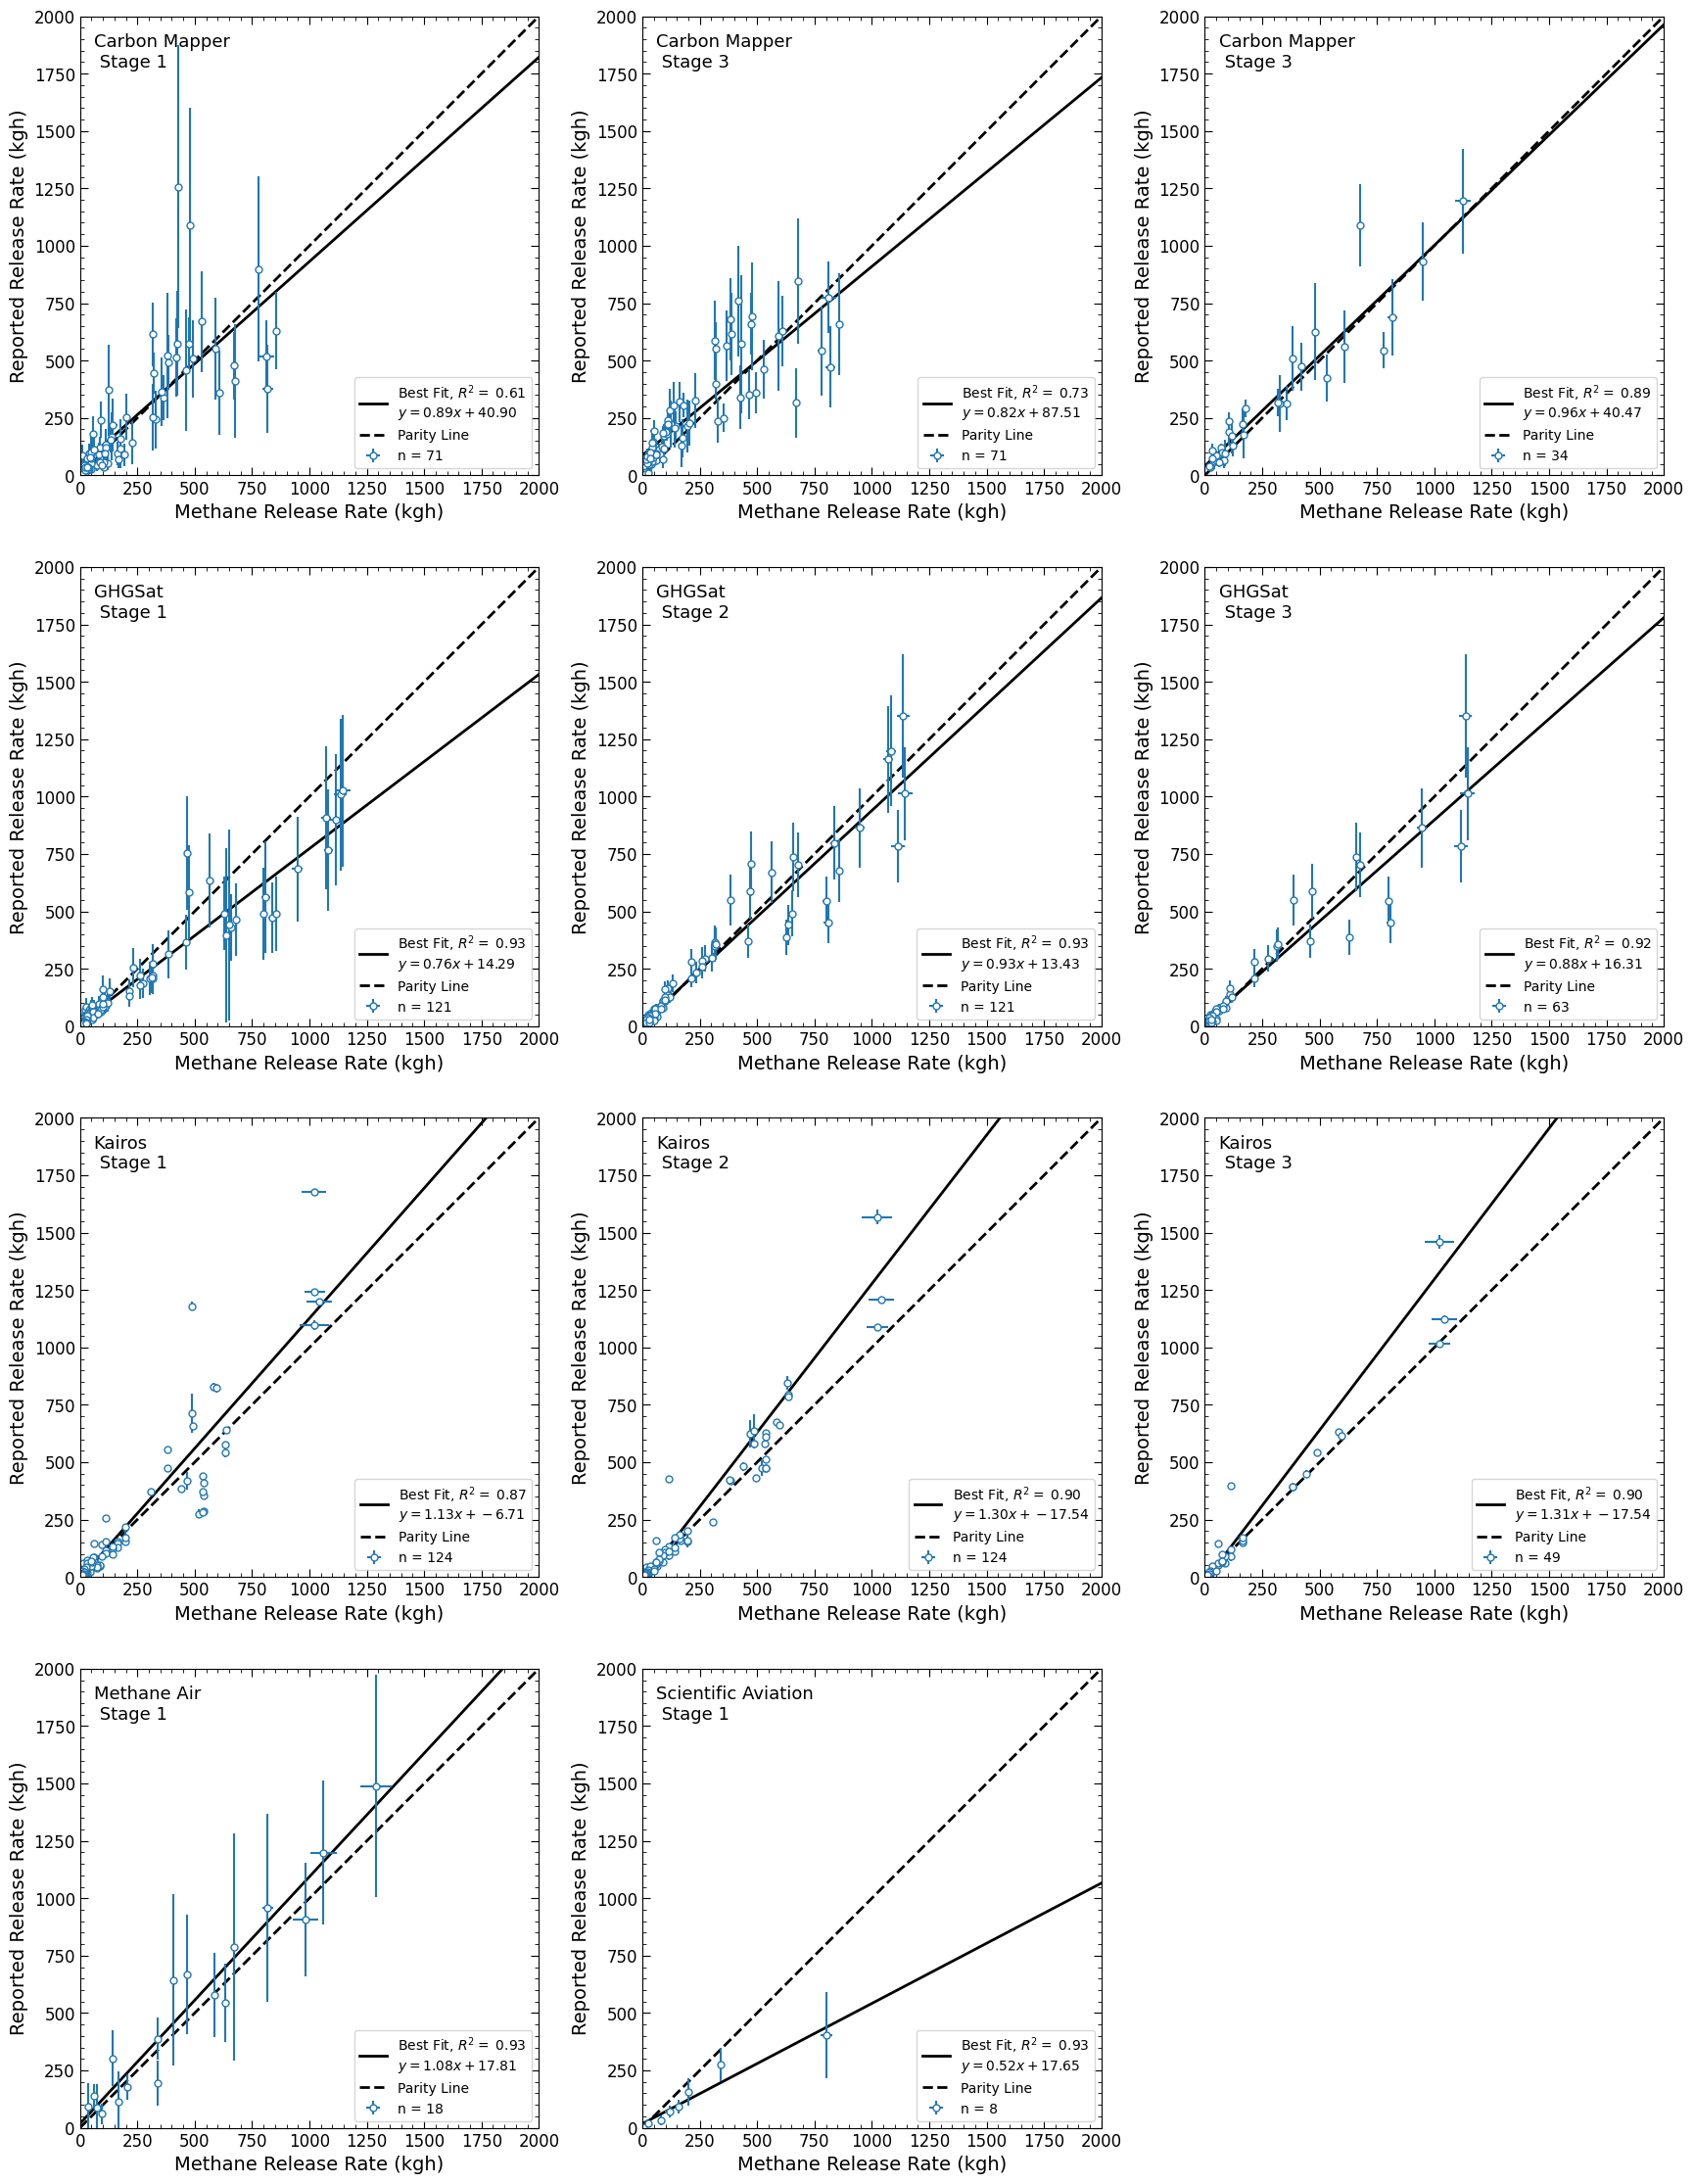

In [8]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from methods_source import load_overpass_summary

def get_parity_data(operator, stage, strict_discard=False, time_ave=60, gas_comp_source='km'):
    """

    :param operator: name of operator
    :param stage: stage of analysis
    :param strict_discard: boolean, True for strict discard, False for lax discard
    :param time_ave: time average period for meter data
    :param gas_comp_source: source of gas composition for CNG
    :return save_parity_data: dataframe with columns release_rate, release_sigma, operator_report, and operator_sigma
    :return data_description: dictionary with key data parameters (operator, stage, strict_discard, time_ave, gas_comp_source)
    """

    # Load overpass summary csv file
    operator_plot = load_overpass_summary(operator, stage, strict_discard, time_ave, gas_comp_source)

    # Apply the following filters to overpass data :
    # Must pass all QC filters:
    operator_plot = operator_plot[(operator_plot.qc_summary == 'pass_all')]

    # For parity plots:
    # All data entries must be a non-zero release
    operator_plot = operator_plot.query('non_zero_release == True')

    # Operator must have quantified the release as non-zero:
    operator_plot = operator_plot.query('operator_quantification > 0')

    # Apply filter for Stage 3 data: remove points for which we gave the team's quantification estimates
    # if phase_iii == 1, then we gave them this release in Phase III dataset
    if stage == 3:
        operator_plot = operator_plot[(operator_plot.phase_iii == 0)]

    # Select values for which operator provided a quantification estimate
    # I think this is old code from when I was including zeros in the parity plot
    # y_index = np.isfinite(operator_plot['operator_quantification'])

    # Select x data
    x_data = operator_plot['release_rate_kgh']
    y_data = operator_plot['operator_quantification']
    x_error = operator_plot['ch4_kgh_sigma']
    y_error = operator_plot['operator_upper'] - operator_plot['operator_quantification']


    # Save data used to make figure
    save_parity_data = pd.DataFrame()
    save_parity_data['release_rate'] = x_data
    save_parity_data['release_sigma'] = x_error
    save_parity_data['operator_report'] = y_data
    save_parity_data['operator_sigma'] = y_error

    # Save data description
    data_description = {
        'operator': operator,
        'stage': stage,
        'strict_discard': strict_discard,
        'time_ave': time_ave,
        'gas_comp_source': gas_comp_source,
        'strict_discard': strict_discard,
    }


    return save_parity_data, data_description

def make_parity_plot(data, data_description, ax, plot_lim='largest_kgh'):
    """
    :param data: processed data to be plotted
    :param data_description: dictionary with descriptions of data used for plot annotations
    :param ax: subplot ax to plot on
    :param plot_lim: limit of x and y axes
    :return: ax: is the plotted parity charg
    """

    ############ Data Preparation and Linear Regression ############

    # Load data description
    operator = data_description['operator']
    stage = data_description['stage']
    time_ave = data_description['time_ave']
    gas_comp_source = data_description['gas_comp_source']
    strict_discard = data_description['strict_discard']

    # Set x and y data and error values
    x_data = data.release_rate
    y_data = data.operator_report
    x_error = data.release_sigma * 1.96 # value is sigma, multiply by 1.96 for 95% CI
    y_error = data.operator_sigma

    # Fit linear regression via least squares with numpy.polyfit
    # m is slope, intercept is b
    m, b = np.polyfit(x_data, y_data, deg=1)

    # Calculate R^2 value
    # (using method described here: https://www.askpython.com/python/coefficient-of-determination)
    correlation_matrix = np.corrcoef(x_data, y_data)
    correlation = correlation_matrix[0, 1]
    r2 = correlation ** 2

    # Number of valid overpasses:
    sample_size = len(y_data)

    # Set x and y max values
    # Manually set largest x and y value by changing largest_kgh here to desired value:
    largest_kgh = max(plot_lim)

    if plot_lim == 'largest_kgh':
        # Filter out NA because operations with NA returns NA
        if np.isnan(max(y_error)) == 1:
            y_error.iloc[:] = 0

        largest_kgh = max(max(x_data), max(y_data)) + max(y_error)
        largest_kgh = math.ceil(largest_kgh / 100) * 100

        # set plot_lim:
        plot_lim = [0, largest_kgh]

    # Create sequence of numbers for plotting linear fit (x)
    x_seq = np.linspace(0, largest_kgh, num=100)

    ############ Generate Figure  ############

    # Add linear regression to in put ax
    ax.plot(x_seq, m * x_seq + b, color='k', lw=2,
             label=f'Best Fit, $R^2 =$ {r2:0.2f}\n$y = {m:0.2f}x+{b:0.2f}$')

    # Add parity line
    ax.plot(x_seq, x_seq, color='k', lw=2, linestyle='--',
             label='Parity Line')

    ax.errorbar(x_data, y_data,
                xerr=x_error,
                yerr=y_error,
                linestyle='none',
                mfc='white',
                label=f'n = {sample_size}',
                fmt='o',
                markersize=5)

    # Set title
    # ax.title(f'{operator} Stage {stage} Results ({sample_size} measurements)')
    ax.annotate(f'{operator}\n Stage {stage}', xy=(0.03, 0.89), xycoords = 'axes fraction', fontsize=13)
    # Set axes
    ax.set(xlim=plot_lim,
           ylim=plot_lim,
           alpha=0.8)

    # Equalize Axes
    ax.set_aspect('equal', adjustable='box')

    # Set axes and background color to white
    ax.set_facecolor('white')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')

    # Axes labels
    ax.set_xlabel('Methane Release Rate (kgh)', fontsize=14)
    ax.set_ylabel('Reported Release Rate (kgh)', fontsize=14)
    ax.tick_params(direction='in', right=True, top=True)
    ax.tick_params(labelsize=12)
    ax.minorticks_on()
    ax.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    ax.tick_params(direction='in', which='minor', length=3, bottom=True, top=True, left=True, right=True)
    ax.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)
    ax.grid(False)  # remove grid lines

    # Legend
    ax.legend(facecolor='white', loc='lower right')

    return ax

cm_1_data, cm_1_notes = get_parity_data('Carbon Mapper', stage = 1)
cm_2_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 2)
cm_3_data, cm_2_notes = get_parity_data('Carbon Mapper', stage = 3)
ghg_1_data, ghg_1_notes = get_parity_data('GHGSat', stage = 1)
ghg_2_data, ghg_2_notes = get_parity_data('GHGSat', stage = 2)
ghg_3_data, ghg_3_notes = get_parity_data('GHGSat', stage = 3)
kairos_1_data, kairos_1_notes = get_parity_data('Kairos', stage=1)
kairos_2_data, kairos_2_notes = get_parity_data('Kairos', stage=2)
kairos_3_data, kairos_3_notes = get_parity_data('Kairos', stage=3)
mair_1_data, mair_1_notes = get_parity_data('Methane Air', stage=1)
sciav_1_data, sciav_1_notes = get_parity_data('Scientific Aviation', stage=1, strict_discard=True)

fig, [[ax1, ax2, ax3],[ax4, ax5, ax6],[ax7, ax8, ax9],[ax10, ax11, ax12]] = plt.subplots(4, 3, figsize=[21, 28])

# Carbon Mapper
ax1 = make_parity_plot(cm_1_data, cm_1_notes, ax1, [0, 2000])
ax2 = make_parity_plot(cm_2_data, cm_2_notes, ax2, [0, 2000])
ax3 = make_parity_plot(cm_3_data, cm_2_notes, ax3, [0, 2000])

print('Making GHGSat plots...')
# GHGSat
ax4 = make_parity_plot(ghg_1_data, ghg_1_notes, ax4, [0, 2000])
ax5 = make_parity_plot(ghg_2_data, ghg_2_notes, ax5, [0, 2000])
ax6 = make_parity_plot(ghg_3_data, ghg_3_notes, ax6, [0, 2000])

print('Making Kairos plots...')
# Kairos
ax7 = make_parity_plot(kairos_1_data, kairos_1_notes, ax7, [0, 2000])
ax8 = make_parity_plot(kairos_2_data, kairos_2_notes, ax8, [0, 2000])
ax9 = make_parity_plot(kairos_3_data, kairos_3_notes, ax9, [0, 2000])

# MethaneAIR
print('Making MethaneAIR plots...')

ax10 = make_parity_plot(mair_1_data, mair_1_notes, ax10, [0, 2000])

# Scientific Aviation
ax11 = make_parity_plot(sciav_1_data, sciav_1_notes, ax11, [0, 2000])

# Turn off last axes
ax12.axis('off')

# Save figure

now = datetime.datetime.now()
save_time = now.strftime("%Y%m%d")
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'combined_parity_{save_time}')
plt.savefig(save_path)
print('Figure saved')